<a href="https://colab.research.google.com/github/carlibeisel/Drains_Lower_Boise_River/blob/main/02_drain_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified by Carli Beisel

Adapted from code written by Bridget Bittmann (2023, Github: bridgetmarie24)

Date originally created: June 29, 2022

Date modified: May 13, 2024

Purpose: This script merges mulitple datasets for drains in the Boise River Basin and sums the daily flow values to understand how drainage flows are changing through time.

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
import os
import seaborn as sns

In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
 ### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

fulltime = glob.glob('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/drainage_flows/IDWRWRAccounting_07202022/*_history.csv') #back to 1987
relate = pd.read_csv('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/drainage_flows/dain_relates.csv')
siteID = relate.dropna()
name_dict = dict(zip(siteID['SiteID'],siteID['NewName']))

full = []
for i in fulltime:
  df = pd.read_csv(i, parse_dates=['HSTDate'])
  df = df.rename({'HSTDate':'Date',
                  'Flow (CFS)': 'CFS'}, axis=1)
  df = df.drop(['SiteType', 'Unnamed: 5', 'Irrigation Year'], axis=1)
  full.append(df)

full= pd.concat(full)
full['Name'] = full['SiteID'].map(name_dict)

half = pd.read_csv('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/drainage_flows/halftime_06292022/BOISE SEWER.csv', parse_dates=['DiversionDate'])
half = half.rename({'DiversionDate':'Date',
                'HydrologyID':'SiteID',
                'DiversionName': 'Name'}, axis=1)
half = half.drop(['WaterDistrictNumber',
              'DiversionTypeDescription',
              'MeasurementTypeDescription'], axis=1)

usgs = pd.read_csv('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/dataretrieval/sandrungulch.csv', parse_dates=['Date'])
usgs = usgs.rename({'site_no':'SiteID',
                  'X_00060_00003':'CFS',
                  'DiversionName':'Name'}, axis=1)
usgs = usgs.drop(['Unnamed: 0', 'agency_cd', 'X_00060_00003_cd'], axis=1)

drains = pd.concat([full, half, usgs])
#Convert cfs to acre-ft/day
drains['Acre_feet'] = drains['CFS']*86400/43559.9

In [4]:
## SET DATE AS INDEX ##

drains = drains.set_index('Date')
drains['Month'] = drains.index.month
drains['Day'] = drains.index.day
drains['Year'] = drains.index.year
drains['DOY'] = drains.index.dayofyear
drains = drains[drains.index.year>=1987]
drains = drains[drains.index.year<2021]

In [5]:
## REMOVE WINTER FLOWS ##

start_end = pd.read_csv('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_input/start_end_dates.csv', parse_dates=['StartDate', 'EndDate'])

start_end['StartDOY'] = start_end['StartDate'].dt.dayofyear
start_end['EndDOY'] = start_end['EndDate'].dt.dayofyear

cropped = []
for i in start_end['Year']:
  time = drains[drains['Year'] == i]
  startdoy = int(start_end['StartDOY'][start_end['Year']==i])
  enddoy = int(start_end['EndDOY'][start_end['Year']==i])
  time = time[time['DOY']>= startdoy]
  time = time[time['DOY']<= enddoy]
  cropped.append(time)

drains = pd.concat(cropped)

<ipython-input-5-23c8e6526c20>:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  startdoy = int(start_end['StartDOY'][start_end['Year']==i])
<ipython-input-5-23c8e6526c20>:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  enddoy = int(start_end['EndDOY'][start_end['Year']==i])


In [6]:
## CALCULATE ANNUAL FLOW SUMS ##

annual_sums = drains.groupby(['Name','Year']).agg({'Acre_feet': ['sum', 'std']})
annual_sums = annual_sums.reset_index()

# Get rid of mutliindex columns
col_name = annual_sums.columns
ind = col_name.to_list()
combine = pd.Index([i[0]+i[1] for i in ind])
annual_sums.columns=combine
annual_sums = annual_sums.rename({'Acre_feetsum': 'Sum_AF',
                                  'Acre_feetstd': 'SD_AF'}, axis=1)

# Export to a csv file

annual_sums.to_csv('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_output/drainage_flows_out/annual_flow_vals.csv')


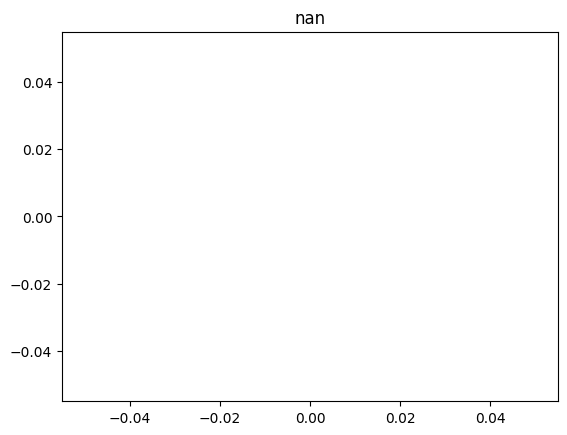

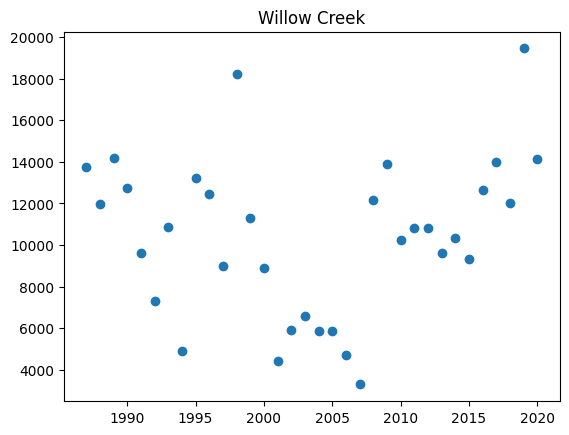

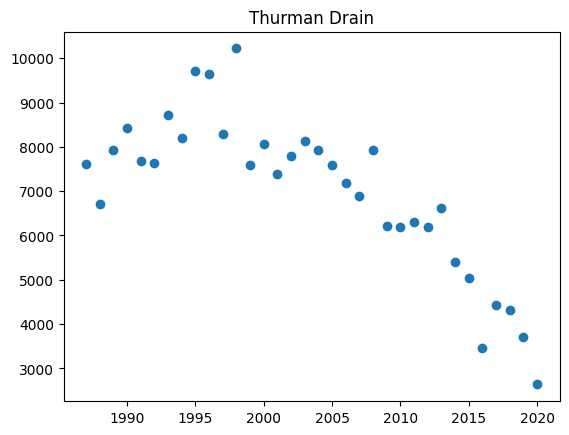

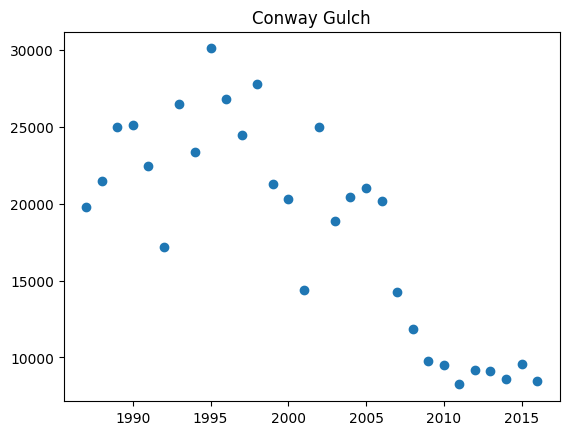

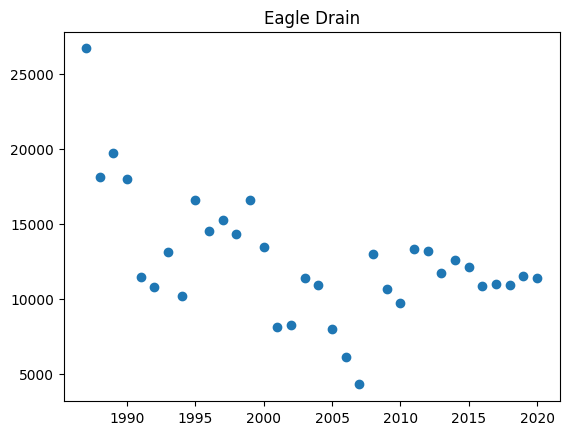

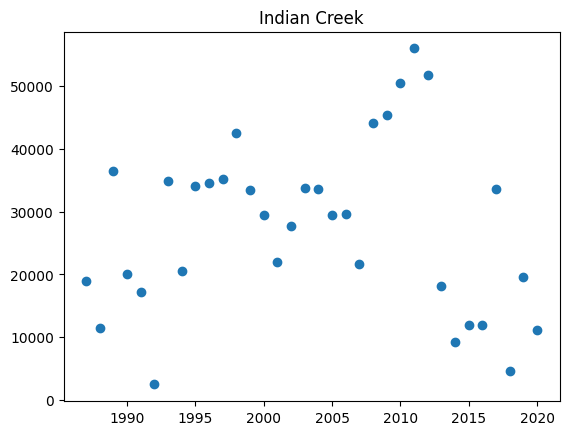

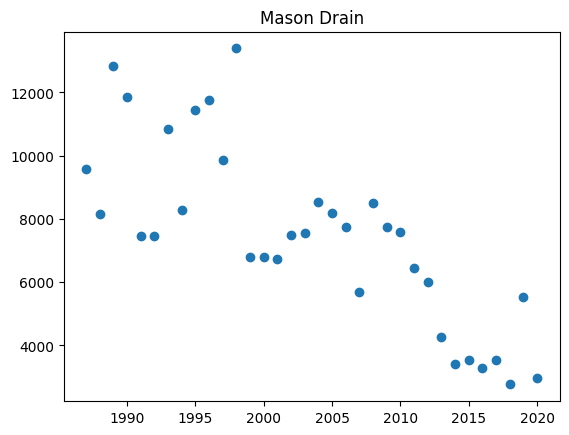

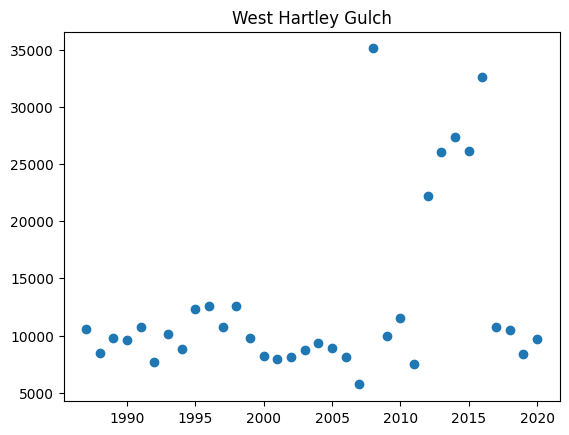

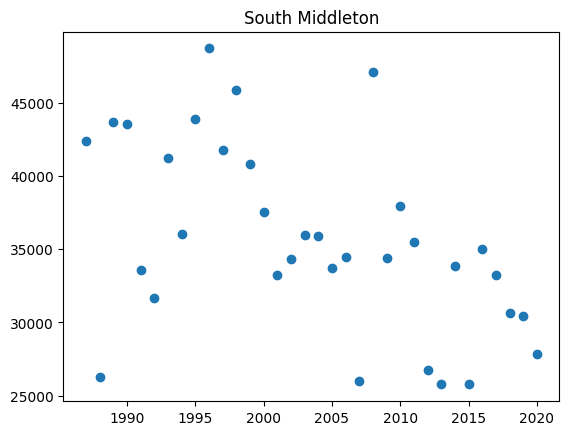

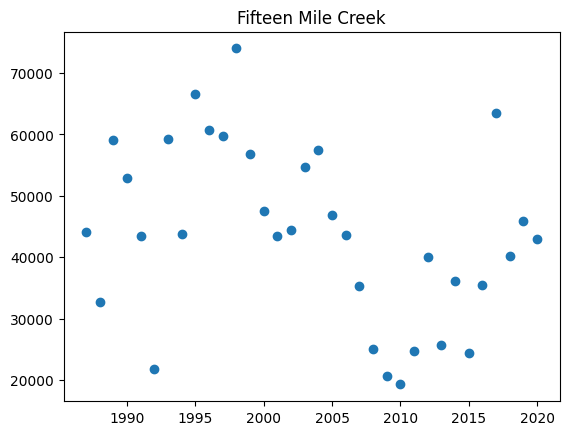

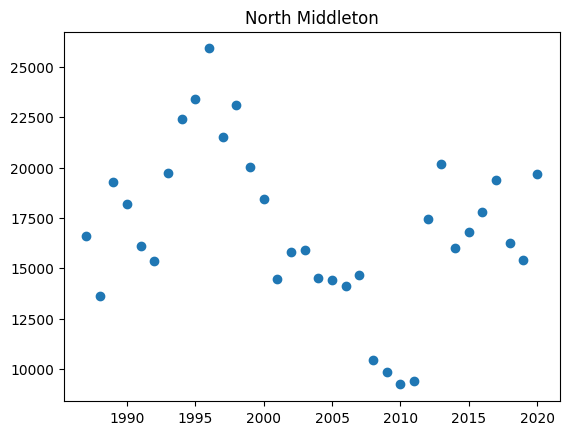

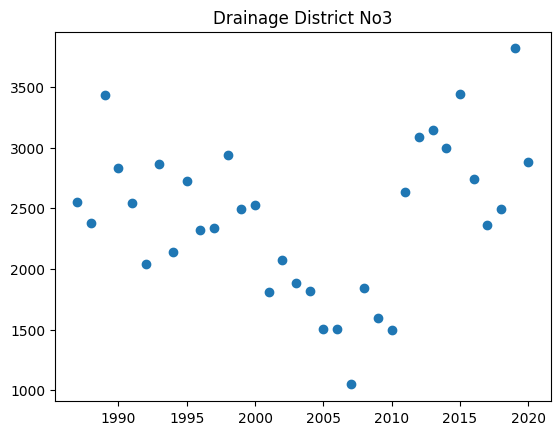

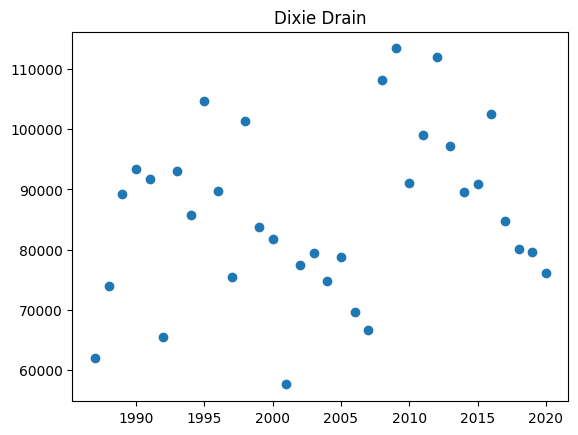

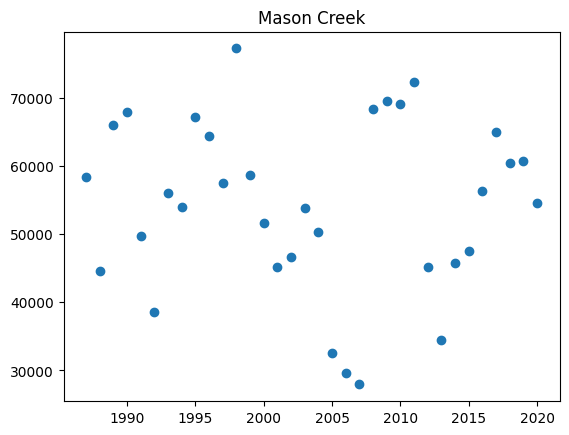

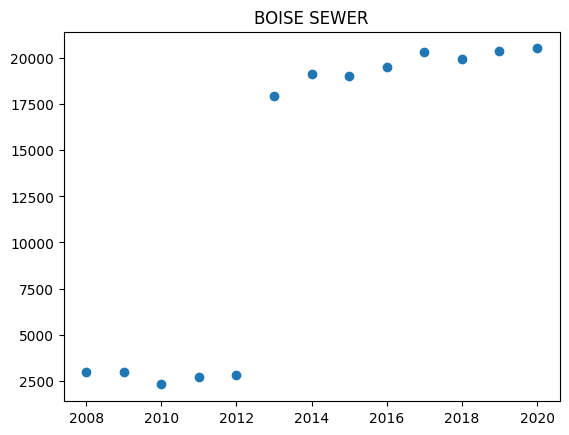

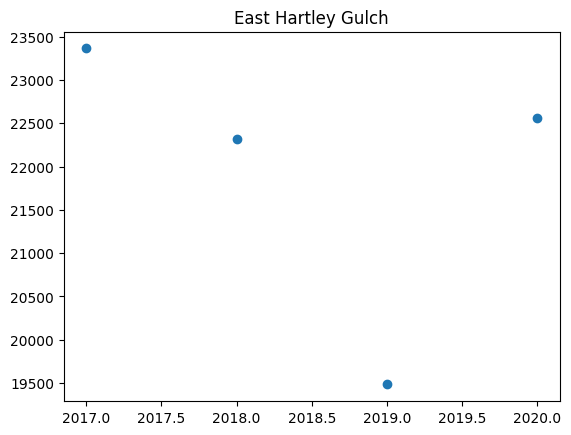

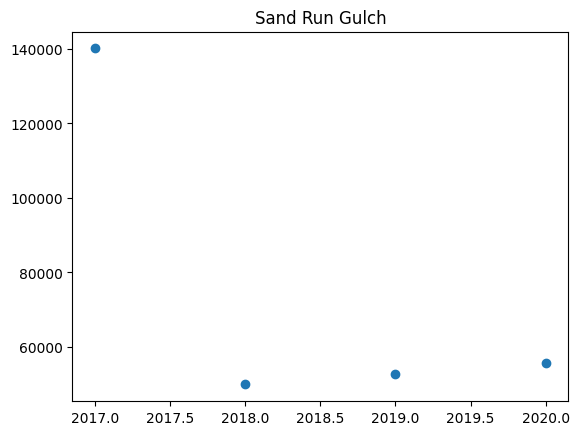

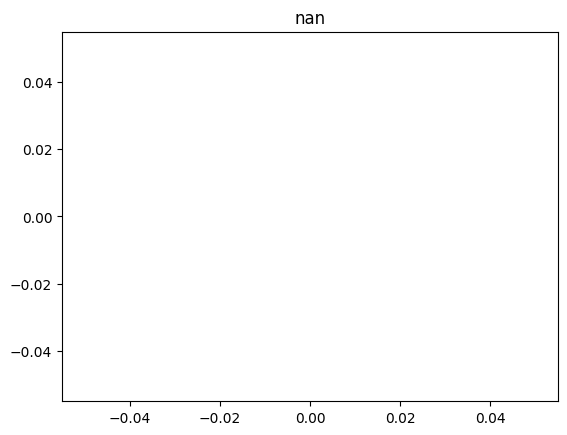

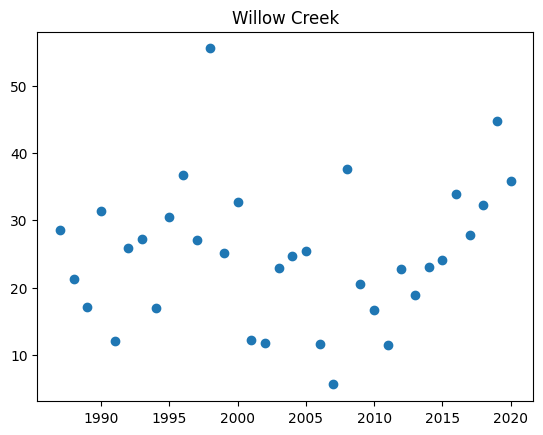

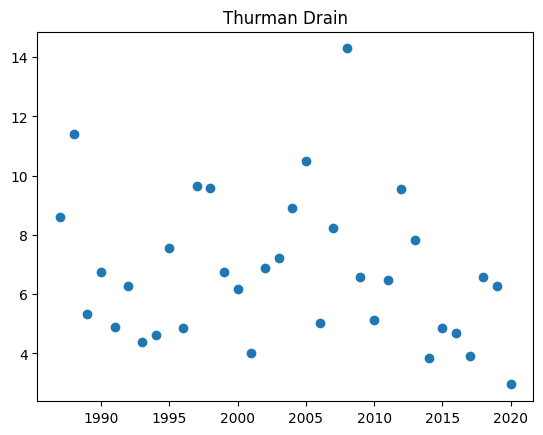

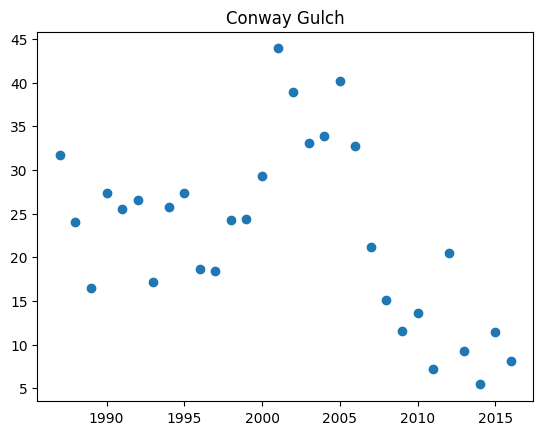

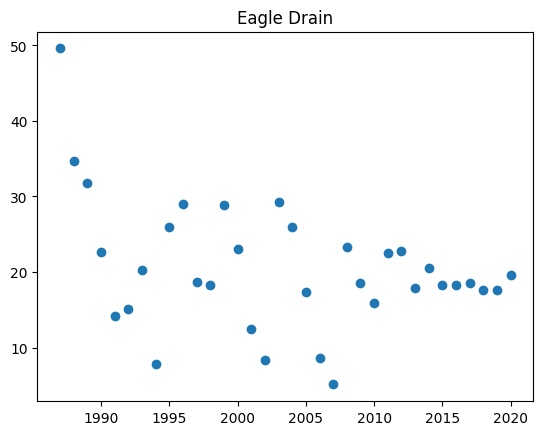

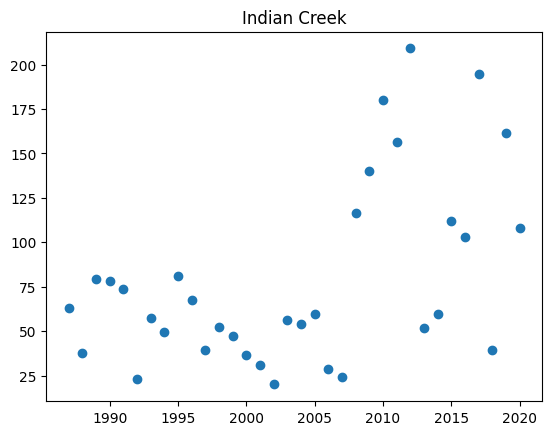

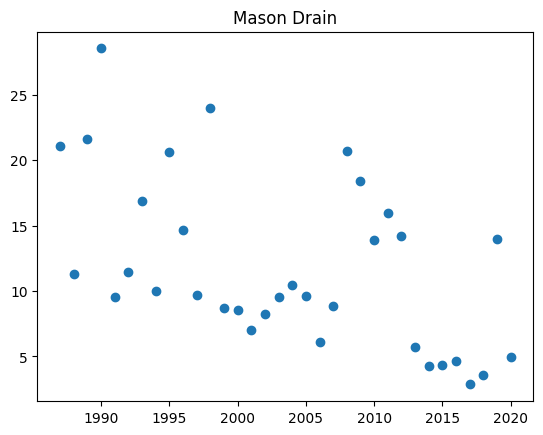

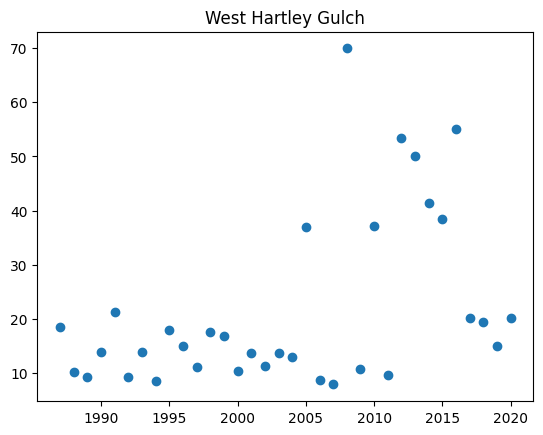

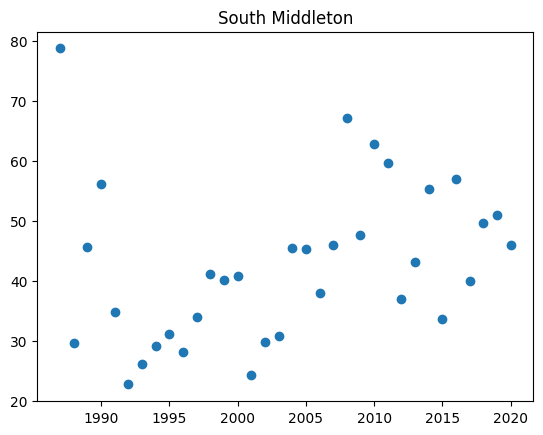

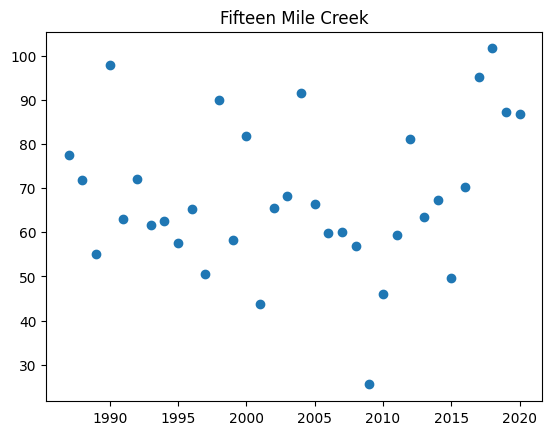

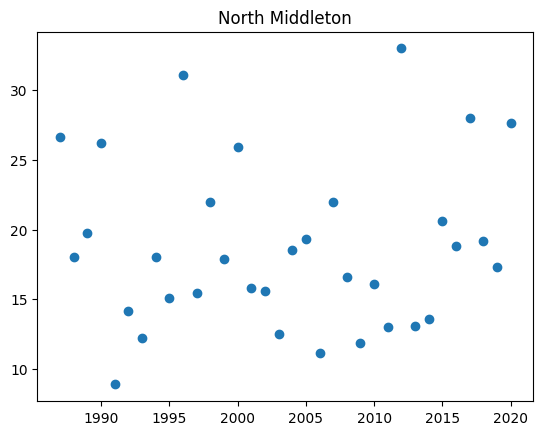

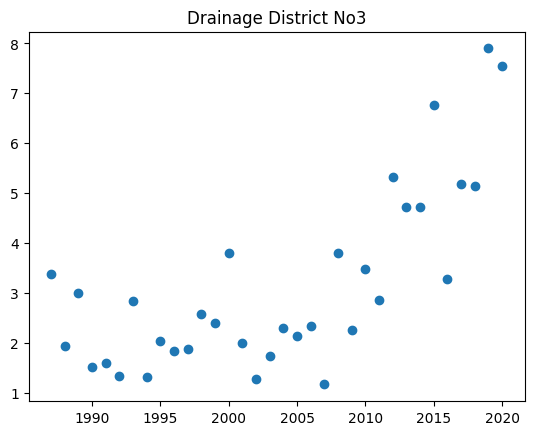

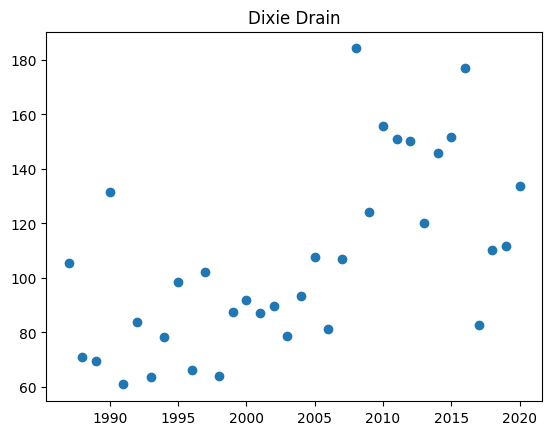

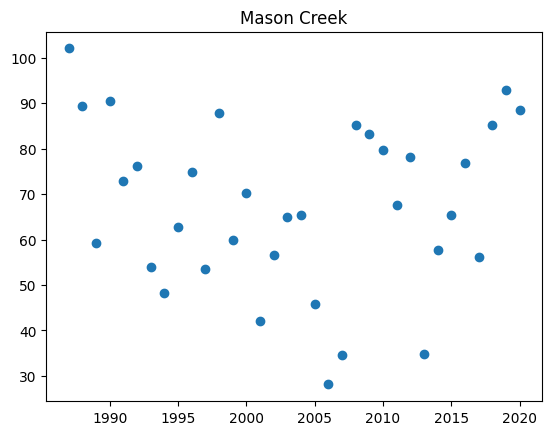

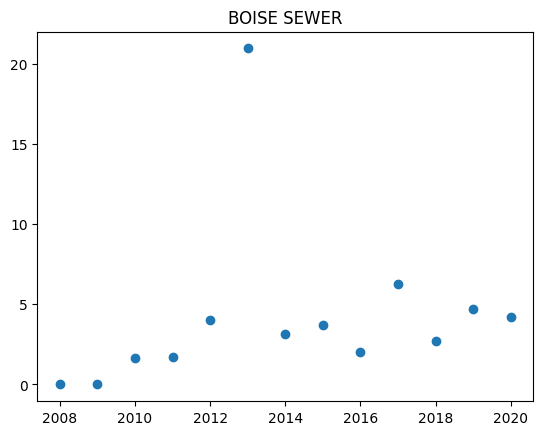

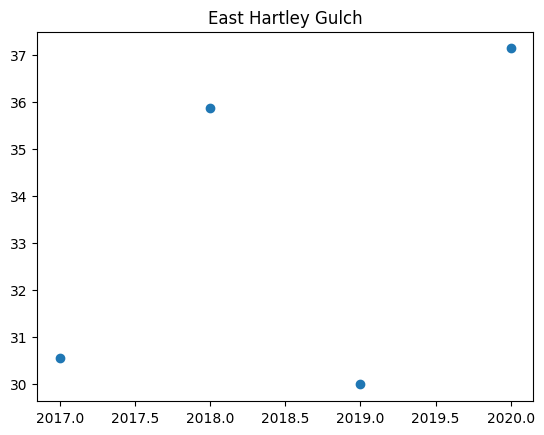

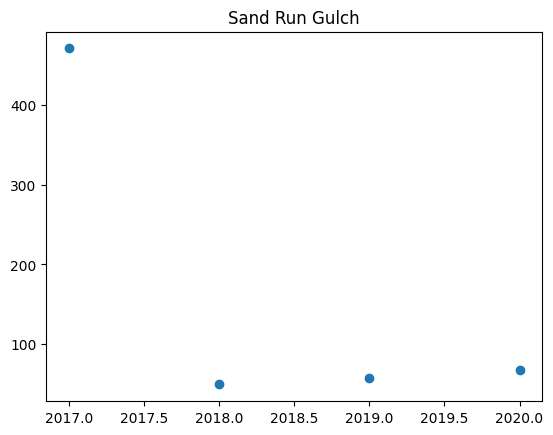

In [7]:
## PLOT ANNUAL FLOWS ##

names = drains['Name'].unique()

for i in names:
  df = annual_sums[annual_sums['Name']==i]
  plt.plot(df['Year'], df['Sum_AF'], 'o')
  plt.title(str(i))
  plt.show()


for i in names:
  df = annual_sums[annual_sums['Name']==i]
  plt.plot(df['Year'], df['SD_AF'], 'o')
  plt.title(str(i))
  plt.show()

In [8]:
# Calculate regressions

names = annual_sums['Name'].unique()
regress = []
rsquared = np.empty(len(names))

for i in range(len(names)):
  df = pd.DataFrame(annual_sums[annual_sums['Name']==names[i]])
  mod = np.polyfit(df['Year'].values, df['Sum_AF'].values, deg=1) #calculates model coefficients
  df['Model'] = np.polyval(mod, df['Year'].values) #calculate model output values
  rsquared[i] = metrics.r2_score(df['Sum_AF'].values, df['Model'].values) #calculate rsquared for model
  regress.append(df)

regression= pd.concat(regress) #put list of dataframes into one

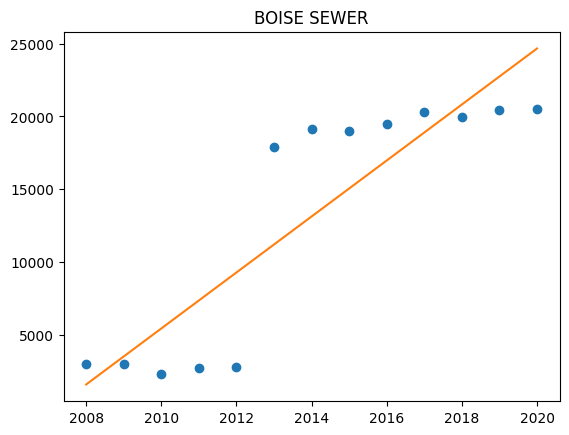

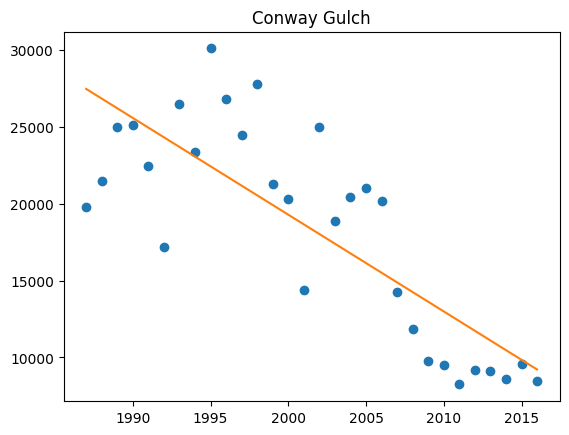

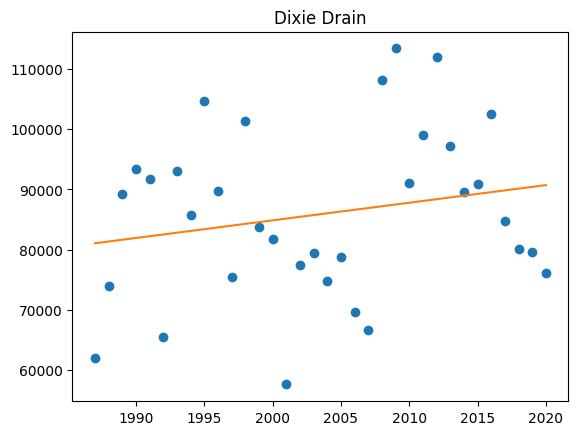

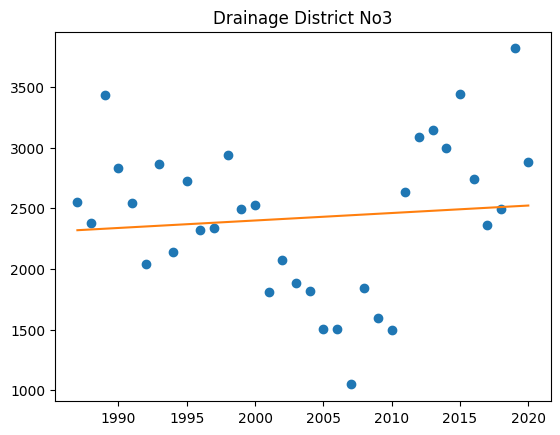

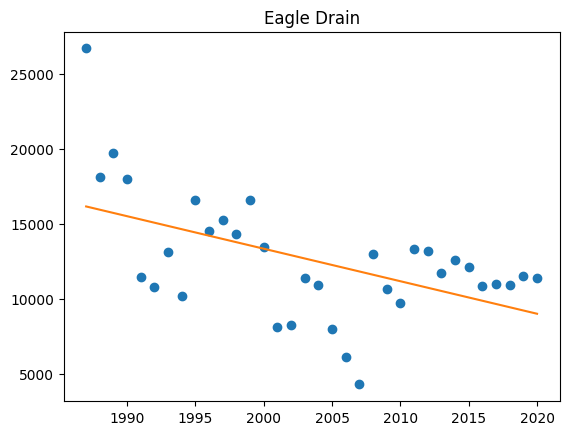

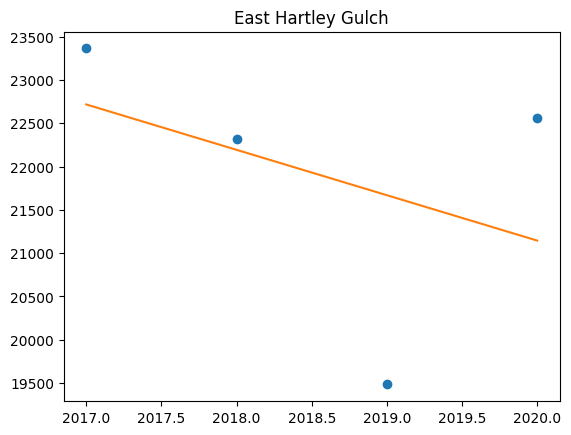

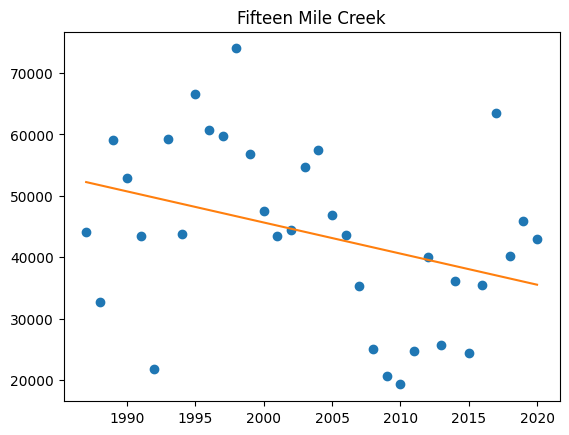

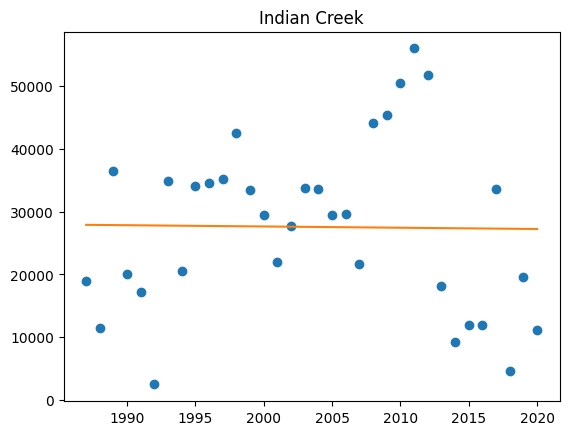

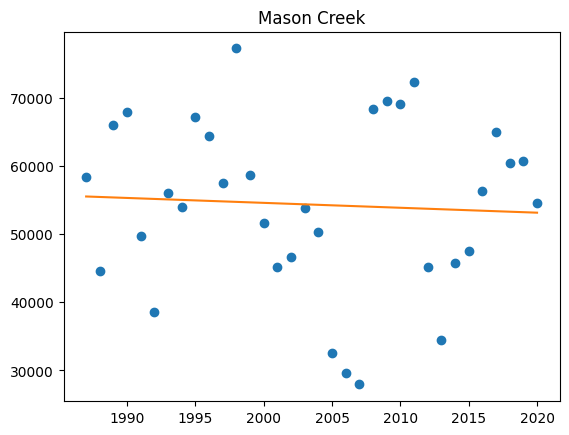

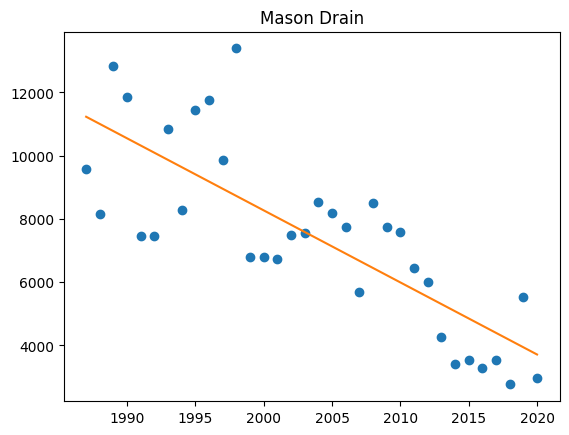

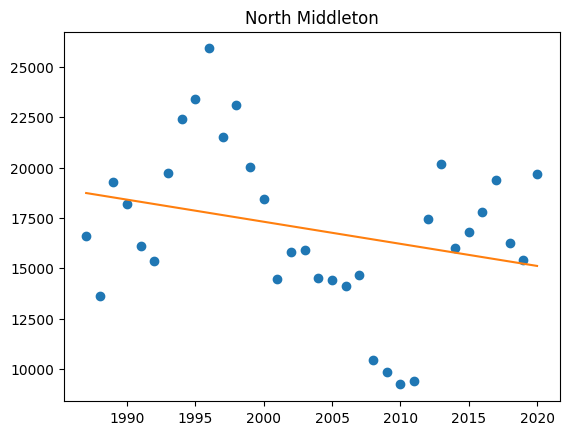

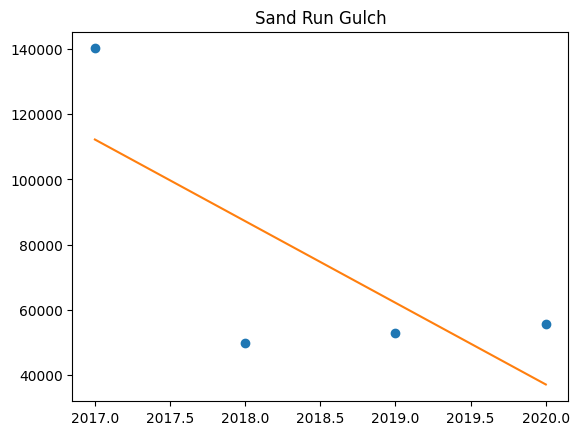

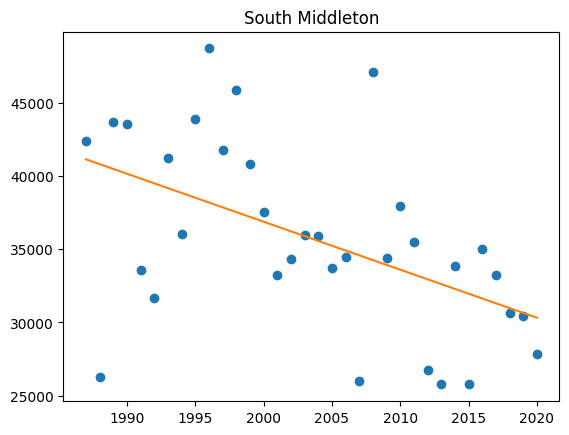

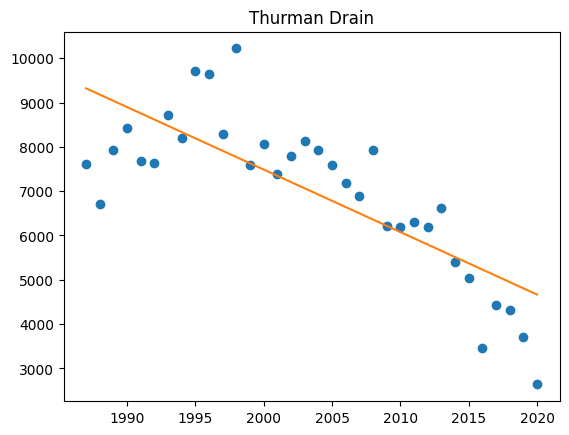

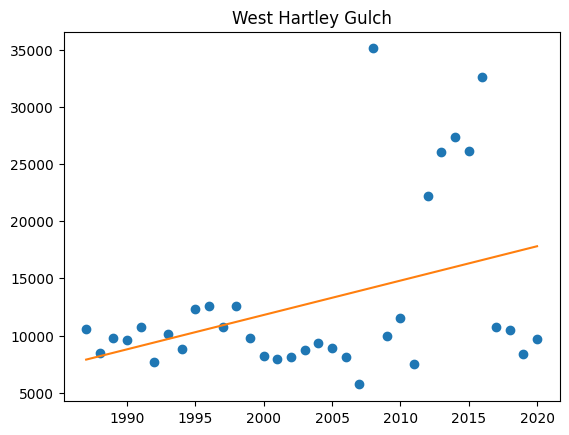

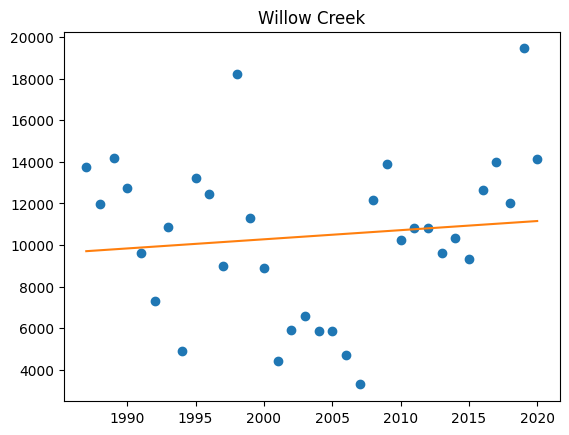

In [9]:
# Plot the regressions

for i in names:
  df = regression[regression['Name']==i]
  plt.plot(df['Year'], df['Sum_AF'], 'o')
  plt.plot(df['Year'], df['Model'])
  plt.title(str(i))
  plt.show()

In [14]:
## Mann Kendall Trend Test
#skips empty data

names = drains['Name'].unique()

outs = []
for i in names:
    drain = annual_sums[annual_sums['Name'] == i]
    input_data = np.array(drain['Sum_AF'])
    # Check if input data is empty
    if len(input_data) > 0:
        test = mk.original_test(input_data, alpha=0.05)
        trend, hyp, pval, slope, inter = [test.trend, test.h, test.p, test.slope, test.intercept]
        outs.append([i, trend, hyp, pval, slope, inter])
    else:
        # If data is empty, append NaN values
        outs.append([i, np.nan, np.nan, np.nan, np.nan, np.nan])

mannkend_annual = pd.DataFrame(outs, columns=['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_annual)

,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,NaN,NaN,NaN,NaN,NaN,NaN
1,Willow Creek,no trend,False,7.895924e-01,22.638670,10430.939649
2,Thurman Drain,decreasing,True,3.979001e-07,-146.186404,10003.531111
3,Conway Gulch,decreasing,True,4.164762e-06,-638.480805,29511.439650
4,Eagle Drain,decreasing,True,5.827257e-03,-203.865231,14991.019539
5,Indian Creek,no trend,False,8.125085e-01,-49.331872,30298.440276
6,Mason Drain,decreasing,True,1.346473e-06,-225.662856,11246.165133
7,West Hartley Gulch,no trend,False,2.858093e-01,54.085880,8991.242031
8,South Middleton,decreasing,True,1.364392e-03,-374.814258,40905.721571
9,Fifteen Mile Creek,decreasing,True,3.528513e-02,-553.315320,52786.596388
